### AudioSignalProcessing

In [30]:
from os.path import join, isdir
import os
from tqdm.auto import tqdm
import librosa
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [4]:
# Подготовка данных
# Используются записи ключевых слов длительностью 1 секунда

downloads = r".\VoiceSamples\YesNoFive10Samples"
input_voice_samples_folders = downloads
output_voice_features_json = join(downloads, "data.json")
output_trained_model = join(downloads, "model.h5")

SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio

def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """
    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {"mapping": [], "labels": [], "MFCCs": [], "files": []}
    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we're at sub-folder level
        if dirpath is not dataset_path:
            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("\\")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))
            # process all audio files in sub-dir and store MFCCs
#             for file in filenames:
            for file in tqdm(filenames):
                file_path = join(dirpath, file)
                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)
                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:
                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]
                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
preprocess_dataset(input_voice_samples_folders, output_voice_features_json)
print('\nCompleted')


Processing: 'five'




Processing: 'no'




Processing: 'yes'




Completed


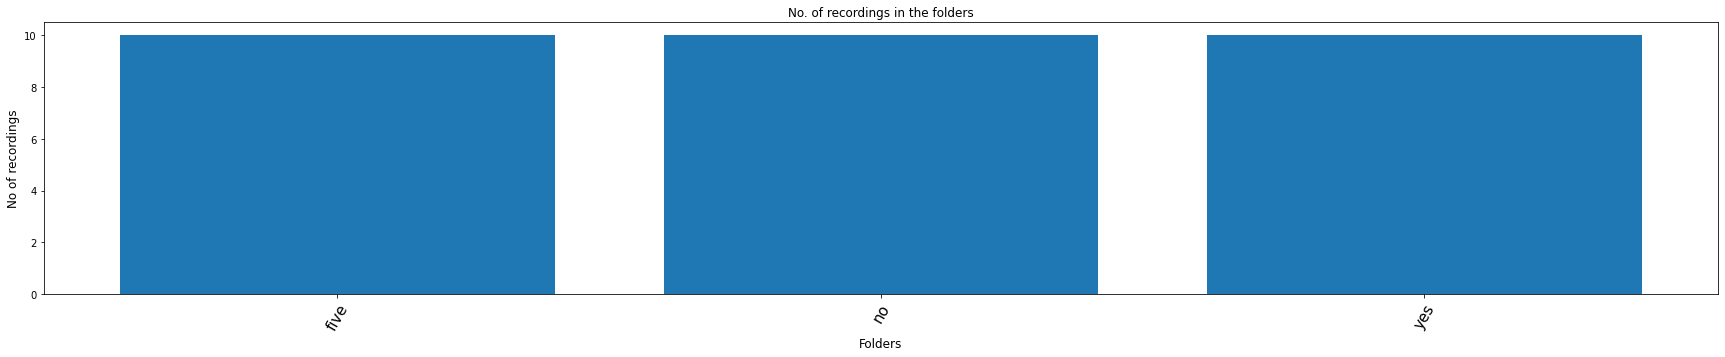

In [28]:
# Проверить кол-во аудиосэмплов каждой фразы

# Folder names with audio samples
labels = [folder for folder in os.listdir(input_voice_samples_folders) 
          if isdir(join(input_voice_samples_folders, folder))]

# Find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# Plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Folders', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings in the folders')
plt.show()

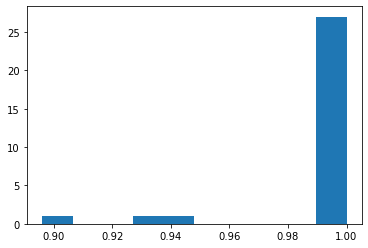

In [33]:
# Проверить длительность сэмплов (в секундах)

duration_of_recordings=[]

for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(join(input_voice_samples_folders, label, wav))
        duration_of_recordings.append(float(len(samples)/sample_rate))  
plt.hist(np.array(duration_of_recordings))

plt.show()